In [1]:
%load_ext autoreload
%autoreload 2

import os
from odc.stac import configure_rio
from dask_jobqueue import SLURMCluster
from dask.distributed import Client as daskClient
from dask import compute as dask_compute
from xarray import open_zarr as xr_open_zarr

from stacathome.walltowall import MaxiCube

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True})

# Construct Cube Object

In [10]:
aoi='somalia'
requested_bands = ['B02', 'B03', 'B04', 'B8A']
resolution = 0.00018
chunksize_xy = 256

out_path = '/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles'
os.makedirs(out_path, exist_ok=True)

mxc = MaxiCube(aoi=aoi,
            requested_bands=requested_bands,
            crs=4326,
            resolution=resolution,
            chunksize_xy=chunksize_xy,
            chunksize_t=1000,
            path=out_path
            )

# Parallel request and download of tiles using SLURM

In [87]:
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    cores=1,                          # Number of cores per job
    memory='768MB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=1, maximum=20)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster

/User/homes/mzehner/micromamba/envs/stacathome/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46379 instead
  warnings.warn(


Dashboard: http://10.0.30.56:46379/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:37467,Workers: 0
Dashboard: http://10.0.30.56:46379/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [92]:
process = mxc.parallel_request('2021-01-01', '2021-01-31')

In [124]:
checked = mxc.check_parallel_request(process)

In [ ]:
mxc.parallel_download(checked)

In [ ]:
client.close()
cluster.close()

In [135]:
mxc.save_items(process)

In [143]:
mxc.plot()

# Load the requested data as on-the-fly xarray

In [141]:
mxc.request_items('2021-01-01', '2021-01-31', subset=0)
mxc.request_items('2021-01-01', '2021-01-31', subset=1000)  # this will add the new request to the existing one, if there are new assets found
mxc.request_items('2021-01-01', '2021-01-31', subset=0, new_request=True)  # overwrite the existing list of requested assets

All data already downloaded.
50 missing assets of 13 items to download.
All data already downloaded.


In [142]:
otf_cube = mxc.load_otf_cube(mxc.req_items_local, mxc.subset(chunk_id=0)[0])
otf_cube

<xarray.Dataset> Size: 4MB
Dimensions:      (latitude: 256, longitude: 256, time: 7)
Coordinates:
  * latitude     (latitude) float64 2kB 12.01 12.01 12.01 ... 11.97 11.97 11.97
  * longitude    (longitude) float64 2kB 50.75 50.75 50.75 ... 50.8 50.8 50.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 56B 2021-01-01T07:03:09.024000 ... 202...
Data variables:
    B02          (time, latitude, longitude) uint16 918kB dask.array<chunksize=(7, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 918kB dask.array<chunksize=(7, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 918kB dask.array<chunksize=(7, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 918kB dask.array<chunksize=(7, 256, 256), meta=np.ndarray>

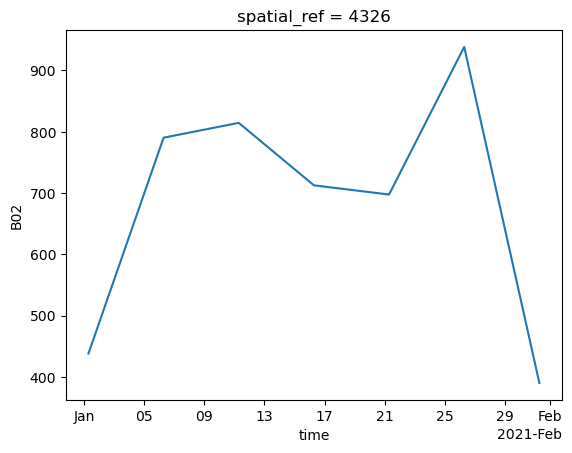

In [62]:
otf_cube.B02.mean(dim=['longitude', 'latitude']).plot()

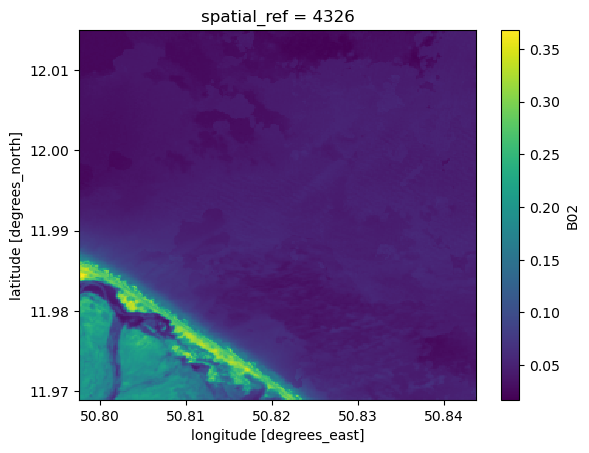

In [31]:
(otf_cube.B02.where(otf_cube.B02 != 0, np.nan).median(dim='time')/10000).plot()

In [171]:
mxc.save_items()

# Prepare to insert data into a larger consistent cube

In [114]:
# setup for large datacube
zarr_store = '/Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026_dask_test.zarr'
mxc.construct_large_cube(zarr_store, overwrite=False)

Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026_dask_test.zarr. Skipping creation. Set overwrite=True to overwrite.


In [115]:
xr_open_zarr(zarr_store)

<xarray.Dataset> Size: 273TB
Dimensions:      (time: 3868, latitude: 75990, longitude: 58076)
Coordinates:
  * latitude     (latitude) float64 608kB 12.01 12.01 12.01 ... -1.663 -1.663
  * longitude    (longitude) float64 465kB 40.98 40.98 40.98 ... 51.44 51.44
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 31kB 2015-06-01 2015-06-02 ... 2026-01-01
Data variables:
    B02          (time, latitude, longitude) float32 68TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 68TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) float32 68TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) float32 68TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>

In [116]:
tasks = mxc.fill_large_cube(subset=[0, 1], kind='requested', dask=True)
tasks

Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026_dask_test.zarr. Skipping creation. Set overwrite=True to overwrite.


[Delayed('delayed_store_chunks_to_zarr-a8c6ddf0-7c75-48f9-9d81-c2445d0a830f'),
 Delayed('delayed_store_chunks_to_zarr-cd5d52d8-4e63-474a-8d45-40f9bad71977'),
 Delayed('delayed_store_chunks_to_zarr-3cc6968c-07d2-4bbc-b0e3-cf22d090143a'),
 Delayed('delayed_store_chunks_to_zarr-73ea1046-eec5-42c7-8290-a2739f996590'),
 Delayed('delayed_store_chunks_to_zarr-e8652b39-63d1-4497-80da-7acb13d43807'),
 Delayed('delayed_store_chunks_to_zarr-c1b7078e-28b8-4e14-81d3-fbf3489a513d'),
 Delayed('delayed_store_chunks_to_zarr-b63f18a3-8770-4660-8a75-9d8f5984f453'),
 Delayed('delayed_store_chunks_to_zarr-4cf2b897-dda4-4b0b-8094-72ce6cc6b901')]

# Save the current cube into large dataset

In [117]:
# Create a SLURM cluster
# Create a SLURM cluster
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    cores=1,                          # Number of cores per job
    memory='32GB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=1, maximum=20)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster
# # Create delayed tasks
# tasks = [fixed_function(i) for i in requested_bands]
# Trigger the execution of these tasks in parallel
# dask.compute(*tasks)

/User/homes/mzehner/micromamba/envs/stacathome/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41719 instead
  warnings.warn(


Dashboard: http://10.0.30.56:41719/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:36245,Workers: 0
Dashboard: http://10.0.30.56:41719/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [118]:
_ = dask_compute(*tasks)


In [139]:
client.close()
cluster.close()

# Addressing the large dataset as a minicube

In [135]:
mc_int = mxc.get_chunk(0, ('2021-01-01', '2021-01-31')).compute()
mc_int  

<xarray.Dataset> Size: 16MB
Dimensions:      (time: 31, latitude: 256, longitude: 256)
Coordinates:
  * latitude     (latitude) float64 2kB 12.01 12.01 12.01 ... 11.97 11.97 11.97
  * longitude    (longitude) float64 2kB 50.75 50.75 50.75 ... 50.8 50.8 50.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 248B 2021-01-01 2021-01-02 ... 2021-01-31
Data variables:
    B02          (time, latitude, longitude) uint16 4MB 179 174 ... 2000 2068
    B03          (time, latitude, longitude) uint16 4MB 139 135 ... 2725 2775
    B04          (time, latitude, longitude) uint16 4MB 87 92 93 ... 3547 3578
    B8A          (time, latitude, longitude) uint16 4MB 81 82 87 ... 4618 4611

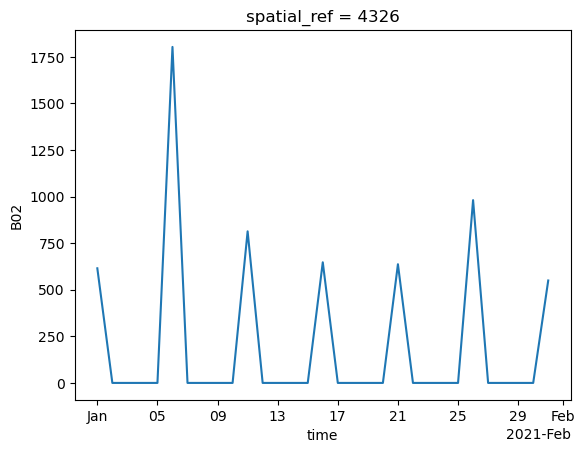

In [136]:
mc_int.B02.mean(dim=['latitude', 'longitude']).plot()

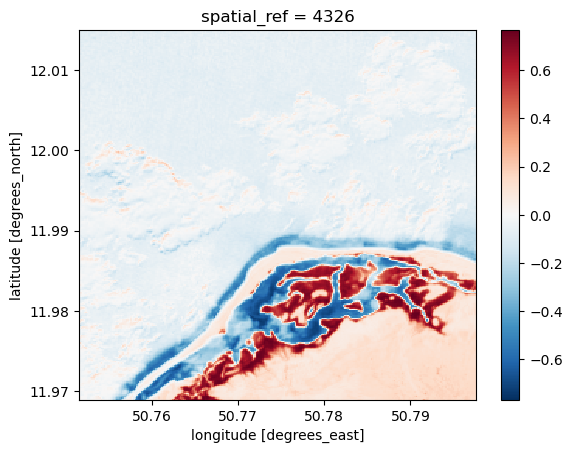

In [137]:
def ndvi(band_red, band_nir):
    return (band_nir - band_red) / (band_nir + band_red)

mc_float = mc_int.where(mc_int.B02 != 0, np.nan).dropna(dim='time', how='all')
ndvi(mc_float.B04.mean(dim='time'), mc_float.B8A.mean(dim='time')).plot.imshow()

In [138]:
mc_float = mxc.get_chunk(0, ('2021-01-01', '2021-01-31'), drop_na=True).compute()
mc_float  

<xarray.Dataset> Size: 15MB
Dimensions:      (time: 7, latitude: 256, longitude: 256)
Coordinates:
  * latitude     (latitude) float64 2kB 12.01 12.01 12.01 ... 11.97 11.97 11.97
  * longitude    (longitude) float64 2kB 50.75 50.75 50.75 ... 50.8 50.8 50.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 56B 2021-01-01 2021-01-06 ... 2021-01-31
Data variables:
    B02          (time, latitude, longitude) float64 4MB 179.0 ... 2.068e+03
    B03          (time, latitude, longitude) float64 4MB 139.0 ... 2.775e+03
    B04          (time, latitude, longitude) float64 4MB 87.0 92.0 ... 3.578e+03
    B8A          (time, latitude, longitude) float64 4MB 81.0 82.0 ... 4.611e+03